## Company classifier notebook

This is for experimenting with the company fit classifier.
Visualizations, etc can go here.

In [1]:
print("hello world")

hello world


### Setup and Imports

In [2]:
import sys
import os
# Add parent directory to Python path so we can import company_classifier
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from company_classifier.classifier import (
    BAD_FIT,
    GOOD_FIT,
    NEED_MORE_INFO,
    CompanyClassifier,
)

### Load and Prepare Data

In [3]:
labels = {
    GOOD_FIT: "Good fit",
    BAD_FIT: "Bad fit",
    NEED_MORE_INFO: "Need more info",
}

In [4]:
def load_real_data(csv_path: str) -> tuple[pd.DataFrame, np.ndarray]:
    """Load and prepare real company data."""
    df = pd.read_csv(csv_path)

    # Map text categories to numeric values
    category_map = {"good": GOOD_FIT, "bad": BAD_FIT, "needs_more_info": NEED_MORE_INFO}

    # Extract features used by our classifier
    X = df[
        [
            "type",
            "total_comp",
            "base",
            "rsu",
            "bonus",
            "remote_policy",
            "eng_size",
            "total_size",
        ]
    ]

    # Convert fit categories to numeric values
    y = df["fit_category"].map(category_map).to_numpy()

    return X, y

# Load the data
X, y = load_real_data("../company_ratings.csv")

# Show dataset info
print(f"Dataset size: {len(X)} companies\n")
print("Class distribution:")
classes, counts = np.unique(y, return_counts=True)
for cls, count in zip(classes, counts):
    label = labels[cls]
    print(f"{label}: {count}")

Dataset size: 48 companies

Class distribution:
Bad fit: 13
Good fit: 13
Need more info: 22


### Train-Test Split and Initial Evaluation

In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Split sizes:")
print(f"Training set: {len(X_train)} companies")
print(f"Test set: {len(X_test)} companies")

# Train and evaluate
print("\nTraining and evaluating classifier...")
classifier = CompanyClassifier()
classifier.fit(X_train, y_train)

# Test set performance
y_pred = classifier.predict(X_test)
print("\nTest Set Performance:")
print(
    classification_report(
        y_test, y_pred, target_names=["Bad fit", "Good fit", "Need more info"]
    )
)

Split sizes:
Training set: 38 companies
Test set: 10 companies

Training and evaluating classifier...

Test Set Performance:
                precision    recall  f1-score   support

       Bad fit       0.50      0.33      0.40         3
      Good fit       1.00      0.33      0.50         3
Need more info       0.43      0.75      0.55         4

      accuracy                           0.50        10
     macro avg       0.64      0.47      0.48        10
  weighted avg       0.62      0.50      0.49        10



/Users/paul/src/recruiter-messager/.direnv/python-3.13/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Cross-Validation Analysis

In [6]:
# Perform cross-validation
cv_results = classifier.cross_validate(
    X, y, cv=5
)

print("Cross-validation results:")
print(
    f"CV Accuracy: {cv_results['test_accuracy'].mean():.2f} (+/- {cv_results['test_accuracy'].std() * 2:.2f})"
)
print(
    f"CV Balanced Accuracy: {cv_results['test_balanced_accuracy'].mean():.2f} (+/- {cv_results['test_balanced_accuracy'].std() * 2:.2f})"
)
print(
    f"CV Precision: {cv_results['test_precision_macro'].mean():.2f} (+/- {cv_results['test_precision_macro'].std() * 2:.2f})"
)
print(
    f"CV Recall: {cv_results['test_recall_macro'].mean():.2f} (+/- {cv_results['test_recall_macro'].std() * 2:.2f})"
)
print(
    f"CV F1: {cv_results['test_f1_macro'].mean():.2f} (+/- {cv_results['test_f1_macro'].std() * 2:.2f})"
)

print("\nTraining vs Test Performance:")
print(f"Training Accuracy: {cv_results['train_accuracy'].mean():.2f}")
print(f"Test Accuracy: {cv_results['test_accuracy'].mean():.2f}")

/Users/paul/src/recruiter-messager/.direnv/python-3.13/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Cross-validation results:
CV Accuracy: 0.69 (+/- 0.34)
CV Balanced Accuracy: 0.69 (+/- 0.32)
CV Precision: 0.74 (+/- 0.36)
CV Recall: 0.69 (+/- 0.32)
CV F1: 0.68 (+/- 0.35)

Training vs Test Performance:
Training Accuracy: 0.98
Test Accuracy: 0.69


/Users/paul/src/recruiter-messager/.direnv/python-3.13/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Feature Importance Analysis


<Figure size 1200x600 with 0 Axes>

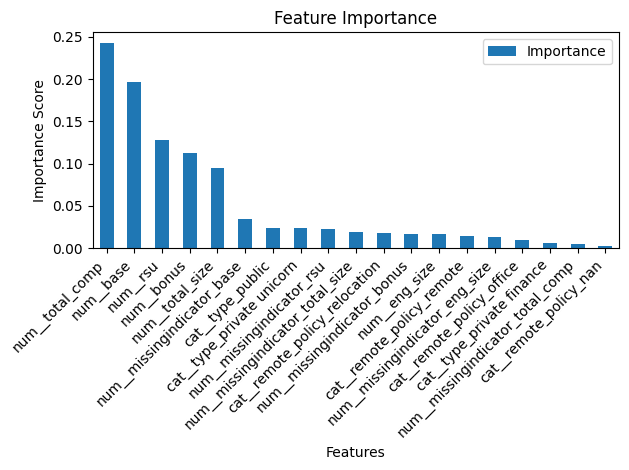

In [7]:
# Analyze feature importance
classifier.fit(X, y)  # Refit on full dataset
importance = classifier.feature_importance()
sorted_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Create a DataFrame for better visualization
importance_df = pd.DataFrame(sorted_features, columns=['Feature', 'Importance'])
importance_df.set_index('Feature', inplace=True)

# Plot feature importance
plt.figure(figsize=(12, 6))
ax = importance_df.plot(kind='bar')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [8]:
# Let's play with some test cases
good_bad_unknown = pd.DataFrame(
    {
        "type": ["public", "private", None],
        "total_comp": [499000, 200, None],
        "base": [399000, 99, None],
        "bonus": [50000, 0, None],
        "rsu": [50000, 0, None],
        "remote_policy": ["hybrid", "relocation required", None],
        "total_size": [5000, 5, None],
        "eng_size": [1000, 2, None],
    })
result = classifier.predict(good_bad_unknown)
for prediction in result:
    print(prediction, labels[prediction])


Need more info
Bad fit
Need more info


/Users/paul/src/recruiter-messager/.direnv/python-3.13/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Analyzing / Visualizing predictions

In [36]:
### Prediction Explanation Tools

from company_classifier import preprocess

def explain_preprocessing(company_data: pd.Series, preprocessor: preprocess.CompanyPreprocessor):
    """Show how each feature is preprocessed."""
    print("Preprocessing Steps:")
    print("-" * 50)
    
    # Show raw input
    print("\nRaw Input:")
    for feature in preprocessor.numeric_features + preprocessor.categorical_features:
        print(f"{feature:15} = {company_data[feature]}")
    
    # Show remote policy normalization
    raw_policy = company_data["remote_policy"]
    normalized_policy = preprocessor.remote_policy_normalizer.transform(pd.Series([raw_policy]))[0]
    print(f"\nRemote Policy Normalization:")
    print(f"Raw      = {raw_policy}")
    print(f"Normalized = {normalized_policy}")
    
    # Show numeric feature handling
    print("\nNumeric Feature Processing:")
    for feature in preprocessor.numeric_features:
        value = company_data[feature]
        is_missing = pd.isna(value)
        final_value = 0 if is_missing else value
        print(f"{feature:15} = {value} -> {final_value} (Missing: {is_missing})")
    
    # Show categorical encoding
    print("\nCategorical Encoding:")
    for feature in preprocessor.categorical_features:
        value = company_data[feature]
        print(f"{feature:15} = {value}")
    
    # Show final feature vector
    transformed = preprocessor.transform(pd.DataFrame([company_data]))
    feature_names = preprocessor.get_feature_names()
    print("\nFinal Feature Vector:")
    for name, value in zip(feature_names, transformed[0]):
        print(f"{name:30} = {value:.3f}")

def explain_random_forest_decision(clf: CompanyClassifier, X_single: pd.DataFrame):
    """Explain how the Random Forest made its decision."""
    # Get preprocessed features
    X_transformed = clf.preprocessor.transform(X_single)
    feature_names = clf.preprocessor.get_feature_names()
    
    # Get probabilities
    probas = clf.predict_proba(X_single)[0]
    prediction = clf.predict(X_single)[0]
    
    print("Random Forest Decision Analysis:")
    print("-" * 50)
    
    # Show class probabilities
    print("\nClass Probabilities:")
    for class_idx, prob in enumerate(probas):
        class_name = labels[class_idx]
        print(f"{class_name:15} = {prob:.3f}")
    
    # Show confidence threshold check
    max_proba = max(probas)
    print(f"\nConfidence Check:")
    print(f"Max probability: {max_proba:.3f}")
    print(f"Threshold: 0.5")
    print(f"Confidence {'sufficient' if max_proba >= 0.5 else 'insufficient'}")
    
    # Show final decision
    print(f"\nFinal Prediction: {labels[prediction]}")
    
    # Show feature importance for this prediction
    importances = clf.feature_importance()
    print("\nTop 5 Most Important Features for Model:")
    sorted_features = sorted(importances.items(), key=lambda x: x[1], reverse=True)[:5]
    for feature, importance in sorted_features:
        print(f"{feature:30} = {importance:.3f}")

def explain_prediction(clf: CompanyClassifier, company_data: pd.Series):
    """Provide a complete explanation of a prediction."""
    print("=" * 80)
    print("Prediction Explanation")
    print("=" * 80)
    
    # Show input summary
    print("\nCompany Summary:")
    print(f"Name: {company_data.get('name', 'N/A')}")
    print(f"Type: {company_data.get('type', 'N/A')}")
    print(f"Total Comp: ${company_data.get('total_comp', 'N/A')}")
    print(f"Remote Policy: {company_data.get('remote_policy', 'N/A')}")
    
    print("\n" + "=" * 80)
    explain_preprocessing(company_data, clf.preprocessor)
    
    print("\n" + "=" * 80)
    explain_random_forest_decision(clf, pd.DataFrame([company_data]))

# Example usage:
# Pick a company you want to understand
company_idx = 1  # Change this to analyze different companies
company_to_explain = good_bad_unknown.iloc[company_idx]
actual_label = labels[y_test[company_idx]]

print(f"Analyzing prediction for company {company_idx}")
print(f"Actual label: {actual_label}")
explain_prediction(classifier, company_to_explain)

Analyzing prediction for company 1
Actual label: Bad fit
Prediction Explanation

Company Summary:
Name: N/A
Type: private
Total Comp: $599000.0
Remote Policy: relocation required

Preprocessing Steps:
--------------------------------------------------

Raw Input:
total_comp      = 599000.0
base            = 499000.0
rsu             = 0.0
bonus           = 100000.0
eng_size        = 2.0
total_size      = 5.0
type            = private
remote_policy   = relocation required

Remote Policy Normalization:
Raw      = relocation required
Normalized = relocation

Numeric Feature Processing:
total_comp      = 599000.0 -> 599000.0 (Missing: False)
base            = 499000.0 -> 499000.0 (Missing: False)
rsu             = 0.0 -> 0.0 (Missing: False)
bonus           = 100000.0 -> 100000.0 (Missing: False)
eng_size        = 2.0 -> 2.0 (Missing: False)
total_size      = 5.0 -> 5.0 (Missing: False)

Categorical Encoding:
type            = private
remote_policy   = relocation required

Final Feature Vec